## 0. Load Data

In [1]:
dataname = 'yeast'

In [2]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
df = pd.read_csv('../datasets/OD/%s/meta_data/%s.original.csv'%(dataname, dataname))
gt = pd.read_csv('../datasets/OD/%s/meta_data/%s.diff.csv'%(dataname, dataname))['ground.truth']
gt_idx = gt.index.values[gt == 'anomaly']

In [3]:
df.head()

Y           M     V   V.1   V.2   V.3  V.4  V.5   V.6   V.7
0  MIT  ADT1_YEAST  0.58  0.61  0.47  0.13  0.5  0.0  0.48  0.22
1  MIT  ADT2_YEAST  0.43  0.67  0.48  0.27  0.5  0.0  0.53  0.22
2  MIT  ADT3_YEAST  0.64  0.62  0.49  0.15  0.5  0.0  0.53  0.22
3  NUC  AAR2_YEAST  0.58  0.44  0.57  0.13  0.5  0.0  0.54  0.22
4  MIT  AATM_YEAST  0.42  0.44  0.48  0.54  0.5  0.0  0.48  0.22

In [4]:
from profiler.core import *

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [5]:
pf = Profiler(workers=2, tol=1e-5, eps=0.05, embedtxt=False)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [6]:
pf.session.load_data(src=DF, df=df, check_param=True)

INFO:profiler.utility:[0.0062139034271240234] Load Data start

INFO:profiler.data.dataset:parameters used for data loading:
 {'na_values': {'?', '', 'none', 'unknown', 'nan', 'None', 'NaN'}, 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.data.dataset:inferred types of attributes: {
    "Y": "text",
    "M": "text",
    "V": "numeric",
    "V.1": "numeric",
    "V.2": "numeric",
    "V.3": "numeric",
    "V.4": "numeric",
    "V.5": "numeric",
    "V.6": "numeric",
    "V.7": "numeric"
}
INFO:profiler.data.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.data.dataset:inferred operators of attributes: {'Y': ['equal'], 'M': ['equal'], 'V': ['equal'], 'V.1': ['equal'], 'V.2': ['equal'], 'V.3': ['equal'], 'V.4': ['equal'], 'V.5': ['equal'], 'V.6': ['equal'], 'V.7': ['equal']}
INFO:profiler.data.dataset:(possible operators: equal, notequal, greater_than, less_th

### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [7]:

# pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
#                             [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
#                             [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

In [8]:
#pf.session.load_embedding(save=True, path='data/hospital/', load=True)

## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [9]:
pf.session.load_training_data(multiplier = None)

INFO:profiler.utility:[0.05201911926269531] Create Training Data start

INFO:profiler.data.transformer:needs multiplier = 32 to bound the error in inv cov estimation <= 0.05000000
INFO:profiler.data.transformer:use multiplier = 32, and the bound is 0.00014964
INFO:profiler.data.transformer:Draw Pairs
100%|██████████| 10/10 [00:00<00:00, 184.80it/s]
INFO:profiler.data.transformer:Number of training samples: 59360
INFO:profiler.data.transformer:Computing Differences
INFO:profiler.data.transformer:estimated missing data probability in training data is 0.0000
INFO:profiler.utility:[0.23669195175170898] Create Training Data execution time: 0.18467283248901367



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [10]:
autoregress_matrix = pf.session.learn_structure(sparsity=0,
                                                infer_order=True)

INFO:profiler.utility:[0.24542999267578125] Learn Structure start

INFO:profiler.learner:use threshold 0.0696
INFO:profiler.utility:[0.36771512031555176] Learn Structure execution time: 0.12228512763977051



* score: 
    * "fit_error": mse for fitting y = B'X + c for each atttribute y 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [11]:
parent_sets = pf.session.get_dependencies(score="fit_error")


INFO:profiler.utility:[0.3744170665740967] Get Dependencies start

INFO:profiler.utility:[0.40787410736083984] Get Dependencies execution time: 0.033457040786743164



V.1,Y -> M (0.002444586762958698)
M -> V (0.09846137661028914)
M -> V.2 (0.11418997454801419)
M -> V.3 (0.10428477519685854)
V.1,Y,M -> V.5 (0.017626981238019757)
M -> V.6 (0.13108764364577266)
M -> V.7 (0.22917225524730456)
V.1,Y,M,V.3 -> V.4 (0.016571477505562624)


## 5. Visualization

In [12]:
pf.session.visualize_covariance()

<Figure size 1000x800 with 2 Axes>

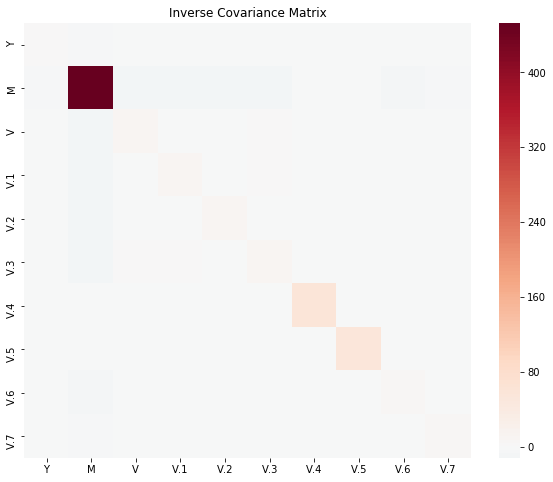

In [13]:
pf.session.visualize_inverse_covariance()

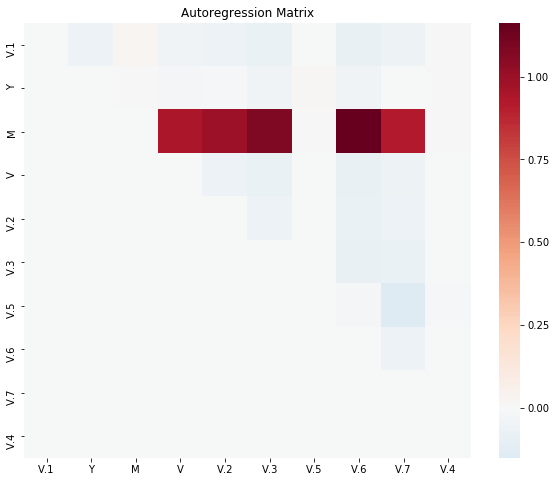

In [14]:
pf.session.visualize_autoregression()

In [15]:
pf.session.timer.get_stat()


time_point                          msg  execution_time
0    0.006214             start: Load Data        0.000000
1    0.027928               end: Load Data        0.021714
2    0.052019  start: Create Training Data        0.000000
3    0.236692    end: Create Training Data        0.184673
4    0.245430       start: Learn Structure        0.000000
5    0.367715         end: Learn Structure        0.122285
6    0.374417      start: Get Dependencies        0.000000
7    0.407874        end: Get Dependencies        0.033457
8    0.407874         total_execution_time        0.362129

In [16]:
from profiler.app.od import *

In [17]:
detector = ScikitDetector(pf.session.ds.df, attr=pf.session.ds.dtypes, method="isf", gt_idx=gt_idx)
detector.run_all(parent_sets)
detector.evaluate()

INFO:profiler.utility:[0.0021619796752929688] naive start

INFO:profiler.utility:[4.226804971694946] naive execution time: 4.224642992019653

INFO:profiler.utility:[4.227467060089111] structured start

 30%|███       | 3/10 [00:00<00:00, 15.19it/s]/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_le

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/p

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:480: RuntimeWarning: invalid value encountered in true_divide
  * _average_path_length([self.max_samples_]))
/Users/zhihan/anaconda

     time_point                   msg  execution_time
0      0.002162          start: naive        0.000000
1      4.226805            end: naive        4.224643
2      4.227467     start: structured        0.000000
3  80454.308818       end: structured    80450.081351
4  80454.308818  total_execution_time    80454.305994
Results for naive approach:
with 766 detected outliers, precision is: 0.3003
with 766 detected outliers, recall is: 0.4536
f1: 0.3614
Results for structure only:
no outlier is found, f1: 0
Results for enhance naive with structured:
with 766 detected outliers, precision is: 0.3003
with 766 detected outliers, recall is: 0.4536
f1: 0.3614


In [21]:
detector2 = ScikitDetector(pf.session.ds.df, attr=pf.session.ds.dtypes, method="ocsvm", gt_idx=gt_idx,
                           nu=0.1, gamma='auto')
detector2.run_all(parent_sets)
detector2.evaluate()

INFO:profiler.utility:[0.0013790130615234375] naive start

INFO:profiler.utility:[1.6274819374084473] naive execution time: 1.6261029243469238

INFO:profiler.utility:[1.6281969547271729] structured start

100%|██████████| 10/10 [00:05<00:00,  1.77it/s]
INFO:profiler.utility:[7.277080059051514] structured execution time: 5.648883104324341



   time_point                   msg  execution_time
0    0.001379          start: naive        0.000000
1    1.627482            end: naive        1.626103
2    1.628197     start: structured        0.000000
3    7.277080       end: structured        5.648883
4    7.277080  total_execution_time        7.274986
Results for naive approach:
with 1484 detected outliers, precision is: 0.3416
with 1484 detected outliers, recall is: 1.0000
f1: 0.5093
Results for structure only:
no outlier is found, f1: 0
Results for enhance naive with structured:
with 1484 detected outliers, precision is: 0.3416
with 1484 detected outliers, recall is: 1.0000
f1: 0.5093
